# Imports

### Import modules

In [1]:
import os
from tqdm import tqdm
import pickle as pkl
import itertools as iter
from matplotlib import pyplot as plt
import sys; sys.path.append('..')
from experiments.functions_Filippo import *
import warnings
import itertools
from IPython.display import Markdown
import io
import pandas as pd
import seaborn as sns
import time
import wfdb
from scipy import signal

from ecgdetectors import Detectors

import torch
torch.manual_seed(0);
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader, random_split


### Import local modules

In [2]:
root = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(0, os.path.join(root, 'src'))


from dataset import dataset_dir
from cs import generate_sensing_matrix
from cs.utils import compute_rsnr
from models.unet import UNet

### Hardware settings

In [3]:
gpus = "3"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=gpus

os.environ['SCIPY_USE_PROPACK'] = "True"

# limit number of parallel threads numpy spawns
workers_mp = 1 # number of workers for mp.pool
threads_np = "1" # number of threads np generates for every worker

os.environ["OMP_NUM_THREADS"] = threads_np
os.environ["OPENBLAS_NUM_THREADS"] = threads_np
os.environ["MKL_NUM_THREADS"] = threads_np
os.environ["VECLIB_MAXIMUM_THREADS"] = threads_np
os.environ["NUMEXPR_NUM_THREADS"] = threads_np
import numpy as np

In [4]:
def cell_vars(pop=None, verbose=False):
    _bundle = get_cell_vars_as_dict(ipy=get_ipython(), out=io.StringIO(), glob=globals(), offset=0)
    
    if pop is not None and pop in _bundle.keys():
        _bundle.pop(pop)

    for k, v in _bundle.items():
        _b = _bundle.copy()
        _b.pop(k)
        if v==_b or v=={}:
            _bundle.pop(k)
            break;
    
    if verbose: [print(k) for k in _bundle]
    return _bundle

# Multi Unet Exploration

In [5]:
bundle_param = {}

### Dataset parameters

In [6]:
# N = 10_000
N = 2_000_000
# N = 100_000
n = 128
n_iddb = 128
n_mit_bih = 128
# seed_ecg = 42
seed_ecg = 11
fs = 256 # sampling freq
hr0 = 60 # heart rate low
hr1 = 100 # hear rate high
isnr = 1000 # dB (intrinsic snr)

_b = cell_vars(pop='_b')

In [7]:
bundle_param = bundle_param | _b

### A parameters

In [8]:
# m = [48]
# m = [16, 32, 48]
m = 32
# N_try_A = [1_000]
N_try_A = 100
mode_A = 'rakeness'
seed_A = 0
index_A = 0
orth = True
str_corr = '96af96a7ddfcb2f6059092c250e18f2a'
loc = 0.25 # localization for rakeness

_b = cell_vars(pop='_b')

In [9]:
bundle_param = bundle_param | _b

### Unet parameters

In [10]:
in_channels = 1
out_channels = 1
# expanded_channels = [64, 32, 16]
expanded_channels = 32
# step_number = [4, 3, 2]
step_number = 3
# kernel_size = [3, 5, 7]
kernel_size = 3
residual = True
use_batch_norm = False
simple_pool = False
# seed_torch = 0
# seed_torch = [0, 1, 2, 3]
seed_torch = [0, 1, 2, 3]
# seed_torch = 0
# seed_torch = [0, 1, 2, 3]
# white_noise_var = 0.001
white_noise_var = 0
white_noise_isnr = [20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0]
# white_noise_isnr = [25.0, 35.5, 45.0]
str_x_as_input = True
str_A_init = True
str_A_freeze = True

_b = cell_vars(pop='_b')

In [11]:
bundle_param = bundle_param | _b

### Dataset for A generation

In [12]:
_ecg_N_forA = 10_000
_n_forA = 128
_fs_forA = 256
_hr0_forA = 60
_hr1_forA = 100
_isnr_forA = 35
_seed_forA = 0

_b = cell_vars(pop='_b')

In [13]:
bundle_param_A_dataset = _b.copy()
bundle_param = bundle_param_A_dataset | bundle_param
for k, v in bundle_param.items():
    if type(v) is list and len(v)==1:
        bundle_param[k] = v[0];

In [14]:
bundle_param

{'_ecg_N_forA': 10000,
 '_n_forA': 128,
 '_fs_forA': 256,
 '_hr0_forA': 60,
 '_hr1_forA': 100,
 '_isnr_forA': 35,
 '_seed_forA': 0,
 'N': 2000000,
 'n': 128,
 'n_iddb': 128,
 'n_mit_bih': 128,
 'seed_ecg': 11,
 'fs': 256,
 'hr0': 60,
 'hr1': 100,
 'isnr': 1000,
 'm': 32,
 'N_try_A': 100,
 'mode_A': 'rakeness',
 'seed_A': 0,
 'index_A': 0,
 'orth': True,
 'str_corr': '96af96a7ddfcb2f6059092c250e18f2a',
 'loc': 0.25,
 'in_channels': 1,
 'out_channels': 1,
 'expanded_channels': 32,
 'step_number': 3,
 'kernel_size': 3,
 'residual': True,
 'use_batch_norm': False,
 'simple_pool': False,
 'seed_torch': [0, 1, 2, 3],
 'white_noise_var': 0,
 'white_noise_isnr': [20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0],
 'str_x_as_input': True,
 'str_A_init': True,
 'str_A_freeze': True}

In [15]:
bundle_param_iter = {_k: _v for _k, _v in bundle_param.items() if type(_v) is list}
bundle_param_iter

{'seed_torch': [0, 1, 2, 3],
 'white_noise_isnr': [20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0]}

#### Select GPU

In [16]:
use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 1
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


### Extract ECG (dataset)

#### SYNTH

In [17]:
path_ecg = from_bundle_to_ecg_path(bundle_param)

with open(path_ecg, 'rb') as f:
    ecg_synth = pkl.load(f)[:, np.newaxis]

#### REAL ECG IDDB

In [18]:


db_dir = 'ecgiddb'
dl_dir = 'miao'
# str_type_signal = 'ECG I filtered'
str_type_signal = 'ECG I'

overlap = n_iddb//5

if not(os.path.exists(dl_dir)):
    wfdb.io.dl_database(db_dir, dl_dir, records='all', annotators=None, keep_subdirs=True, overwrite=False)

ecg_iddb = None
ecg_iddb_filt = None

for _p in os.listdir(dl_dir):
    _path = os.path.join(dl_dir, _p)
    
    for _p2 in os.listdir(_path):

        if _p2[-4:] == '.dat':

            _p2 = _p2.replace('.dat', '')

            _path2 = os.path.join(_path, _p2)

            record = wfdb.io.rdrecord(_path2)
            
            _fs = record.fs

            record, record_filt = record.to_dataframe()['ECG I'].to_numpy(), record.to_dataframe()['ECG I filtered'].to_numpy()
            
            record = signal.resample_poly(record, fs, _fs)
            record_filt = signal.resample_poly(record_filt, fs, _fs)

            record = split_with_overlap(record, segment_length=n_iddb, overlap=overlap)
            record_filt = split_with_overlap(record_filt, segment_length=n_iddb, overlap=overlap)

            if ecg_iddb is None:
                ecg_iddb = record
                ecg_iddb_filt = record_filt

            else:
                ecg_iddb = np.append(ecg_iddb, record, axis=-2)
                ecg_iddb_filt = np.append(ecg_iddb_filt, record_filt, axis=-2)


            
ecg_iddb = ecg_iddb[1:, np.newaxis]
ecg_iddb_filt = ecg_iddb_filt[1:, np.newaxis]

#### REAL ECG MIT-BIH-Arrhythmia

In [19]:
db_dir = 'mitdb'
dl_dir = 'MIT-BIH-Arrhythmia'


if not(os.path.exists(dl_dir)):
    wfdb.io.dl_database(db_dir, dl_dir, records='all', annotators='all', keep_subdirs=True, overwrite=False)

overlap = n_mit_bih//5

ecg_mit_bih = None
ecg_mit_bih_r_peaks = None


listdir = os.listdir(dl_dir)
listdir = np.unique([s.split('.')[0] for s in listdir])

for _p2 in tqdm(listdir):
    
    ### .dat & .atr

    _path2 = os.path.join(dl_dir, _p2)

    record = wfdb.io.rdrecord(_path2)
    ann = wfdb.io.rdann(_path2, extension='atr')
    
    _fs = record.fs
    
    record = record.p_signal[:, 0]
    record = signal.resample_poly(record, fs, _fs)
    r_peaks_ind = np.array(ann.sample)

    r_peaks_ind = np.floor(r_peaks_ind * fs / _fs).astype(int)
    
    r_peaks = np.zeros(np.shape(record))
    
    r_peaks[r_peaks_ind] = 1

    record = split_with_overlap(record, segment_length=n_mit_bih, overlap=overlap)
    r_peaks = split_with_overlap(r_peaks, segment_length=n_mit_bih, overlap=overlap)

    if ecg_mit_bih is None:
        ecg_mit_bih = record
        ecg_mit_bih_r_peaks = r_peaks

    else:
        ecg_mit_bih = np.append(ecg_mit_bih, record, axis=-2)
        ecg_mit_bih_r_peaks = np.append(ecg_mit_bih_r_peaks, r_peaks, axis=-2)
        
ecg_mit_bih = ecg_mit_bih[:, np.newaxis]

100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


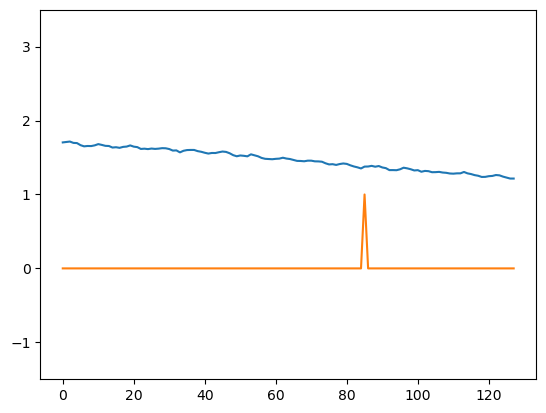

In [20]:
_ind = np.random.randint(0, len(ecg_mit_bih_r_peaks))
plt.plot(ecg_mit_bih[_ind][0])
plt.ylim(-1.5, 3.5)
plt.plot(ecg_mit_bih_r_peaks[_ind],)


### ECG peak detections

[81]
[74]


IndexError: pop from empty list

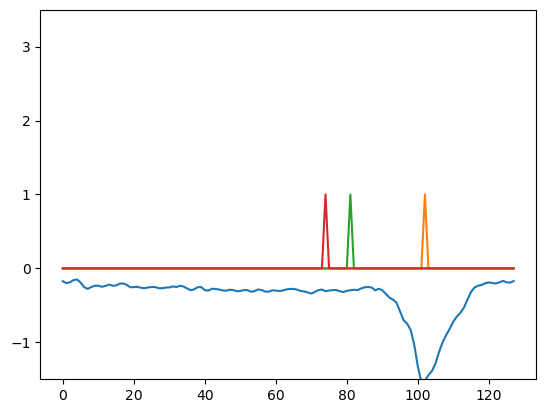

In [21]:
_ind = np.random.randint(0, len(ecg_mit_bih_r_peaks))
_ecg = ecg_mit_bih[_ind][0]
plt.plot(_ecg)
plt.ylim(-1.5, 3.5)
plt.plot(ecg_mit_bih_r_peaks[_ind], label='label')

detectors = Detectors(fs)
r_peaks = detectors.hamilton_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
plt.plot(_z, label='hamilton')

r_peaks = detectors.christov_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
plt.plot(_z, label='christov')

r_peaks = detectors.engzee_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
plt.plot(_z, label='engzee')

r_peaks = detectors.pan_tompkins_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
plt.plot(_z, label='pan_tompkins')

r_peaks = detectors.swt_detector(_ecg)
print(r_peaks)
_z = np.zeros(np.shape(_ecg))
_z[r_peaks] = 1
plt.plot(_z, label='swt')

plt.legend()

### Extract A (sensing matrix)

In [22]:
dict_A = {}
for _mode_A, _m, _N_try_A in itertools.product(
    *to_list(bundle_param['mode_A'], bundle_param['m'], bundle_param['N_try_A'])):

    _bundle_param = bundle_param.copy()
    _bundle_param['mode_A'] = _mode_A
    _bundle_param['m'] = _m
    _bundle_param['N_try_A'] = _N_try_A
    path_A = from_bundle_to_A_path(_bundle_param)


    print(path_A)
    # assert False
    if os.path.isfile(path_A):
        with open(path_A, 'rb') as f:
            A = pkl.load(f)[0]
        print(f"Loading sensing matrix", _mode_A,
                f"(rsnr: {A['rsnr']:.2f}dB (with bpdn) -- seed: {A['seed']})")
        dict_A[_mode_A] = A['matrix']

    else:
        warnings.warn("Sensing matrix generation. "\
                        "Generate with 'best_A_bpdn' for better performances")
        
        path_corr = os.path.join(dataset_dir, 'correlation', str_corr + '.pkl')
        with open(path_corr, 'rb') as f: corr = pkl.load(f)
        
        dict_A[_mode_A] = generate_sensing_matrix(
                    shape = (_m, n), 
                    mode=_mode_A, 
                    antipodal=False, 
                    orthogonal=orth,
                    correlation=corr,
                    loc=.25, 
                    seed=seed_A)
        print('generated A', _mode_A)

/srv/newpenny/dnn-cs/tsoc/data/ecg_N=10000_n=128_fs=256_hr=60-100_isnr=35_seed=0/A_Filippo/sensing_matrix_M=100_m=32_mode=rakeness_seed=0_loc=0.25_corr=96af96a7ddfcb2f6059092c250e18f2a.pkl
Loading sensing matrix rakeness (rsnr: 20.49dB (with bpdn) -- seed: 1651)


In [23]:
isnr_test = 1000

axis = -1
norm_signal = np.mean(np.linalg.norm(ecg_synth, axis=axis))
norm_noise = norm_signal / 10**(isnr_test / 20)
white_noise_var_test = norm_noise / np.sqrt(ecg_synth.shape[axis])
print(white_noise_var_test)

2.6016055826742725e-51


In [24]:
transform = AddGaussianNoise(std=white_noise_var)
df_test_loader_synth = from_ecg_to_df_loader(ecg_synth, 
                                      dict_A,
                                      in_channels, 
                                      str_x_as_input,
                                      64,
                                      transform=transform,
                                      transform_test=True)

df_test_loader_iddb = from_ecg_to_df_loader(ecg_iddb, 
                                      dict_A,
                                      in_channels, 
                                      str_x_as_input,
                                      64)

df_test_loader_mit_bih = from_ecg_to_df_loader(ecg_mit_bih, 
                                      dict_A,
                                      in_channels, 
                                      str_x_as_input,
                                      64)

In [25]:
dict_test_loader_synth = {'rakeness': df_test_loader_synth.iloc[2]['data_loader']}
dict_test_loader_iddb = {'rakeness': df_test_loader_iddb.iloc[2]['data_loader']}
dict_test_loader_mit_bih = {'rakeness': df_test_loader_mit_bih.iloc[2]['data_loader']}

### Path and Loading

In [61]:
verbose_load  = True
verbose_debug = False
bundle_all, param_unique_list = unravel_bundle_param(bundle_param)
print('LOADING MODELS:')
model_list = np.array([from_bundle_to_model(b, device, A=A['matrix'], verbose=verbose_debug) for b in tqdm(bundle_all)])

ind_loaded = model_list!=None

print()
print(f"TOTAL  number of models: {len(model_list)}\n")
print(f"LOADED number of models: {len(model_list[ind_loaded])}\n")

if verbose_load:
    for _m, _p in zip(model_list, param_unique_list):
        if _m is not None:
            display(Markdown(color('LOADED:  ', '', _p, code="00ffff")));
        else:
            display(Markdown(color('MISSING: ', '', _p)));

model_list = model_list[ind_loaded]
param_unique_list = np.array(param_unique_list)[ind_loaded] 
bundle_loaded = np.array(bundle_all)[ind_loaded]

LOADING MODELS:


100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


TOTAL  number of models: 32

LOADED number of models: 32



<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 20.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 25.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 30.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 35.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 40.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 45.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 50.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 0, 'white_noise_isnr': 55.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 20.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 25.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 30.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 35.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 40.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 45.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 50.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 1, 'white_noise_isnr': 55.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 20.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 25.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 30.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 35.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 40.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 45.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 50.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 2, 'white_noise_isnr': 55.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 20.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 25.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 30.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 35.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 40.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 45.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 50.0}

<span style='color: #00ffff'>LOADED:  </span>{'seed_torch': 3, 'white_noise_isnr': 55.0}

In [70]:
df_param_unique = pd.DataFrame(list(param_unique_list))
df_param_unique['model'] = model_list
df_bundle_loaded = pd.DataFrame(list(bundle_loaded))
df_bundle_loaded['model'] = model_list

### Test Models

In [27]:
criterion = nn.MSELoss()

In [ ]:
list_res_iddb = test_model(model_list, param_unique_list, 
                           bundle_loaded, dict_test_loader_iddb, 
                           device, criterion, compute_rsnr)

df_res_iddb = pd.DataFrame(list_res_iddb).rename(columns={'SNR': 'SNR_iddb'}, inplace=True)
df_res_iddb

100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


,seed_torch,white_noise_isnr,SNR
0,0,20.0,7.486167
1,0,25.0,7.956934
2,0,30.0,8.195643
3,0,35.0,8.688719
4,0,40.0,7.296960
5,0,45.0,9.165399
6,0,50.0,9.231647
7,0,55.0,8.893234
8,1,20.0,6.969467
9,1,25.0,6.805835


In [ ]:
list_res_mit_bih = test_model(model_list, param_unique_list, 
                           bundle_loaded, dict_test_loader_mit_bih, 
                           device, criterion, compute_rsnr)

df_res_mit_bih = pd.DataFrame(list_res_mit_bih).rename(columns={'SNR': 'SNR_mit_bih'}, inplace=True)
df_res_mit_bih

100%|██████████| 32/32 [04:39<00:00,  8.74s/it]


,seed_torch,white_noise_isnr,SNR
0,0,20.0,10.380116
1,0,25.0,11.579282
2,0,30.0,12.875220
3,0,35.0,13.438989
4,0,40.0,11.763893
5,0,45.0,14.940818
6,0,50.0,14.052678
7,0,55.0,14.052230
8,1,20.0,8.664681
9,1,25.0,7.385890


In [ ]:
list_res_synth = test_model(model_list, param_unique_list, 
                           bundle_loaded, dict_test_loader_synth, 
                           device, criterion, compute_rsnr)

df_res_synth = pd.DataFrame(list_res_synth).rename(columns={'SNR': 'SNR_synth'}, inplace=True)
df_res_synth

100%|██████████| 32/32 [26:45<00:00, 50.18s/it]


,seed_torch,white_noise_isnr,SNR
0,0,20.0,41.612180
1,0,25.0,44.250706
2,0,30.0,46.618938
3,0,35.0,49.128206
4,0,40.0,36.527073
5,0,45.0,52.043029
6,0,50.0,52.438666
7,0,55.0,48.887111
8,1,20.0,41.593888
9,1,25.0,44.250966


#### Group by

In [41]:
df_res = df_res_iddb.merge(df_res_mit_bih, on=['seed_torch', 'white_noise_isnr'], how='inner', suffixes=('', '_dup'))
if 'df_res_synth' in locals():
    df_res = df_res.merge(df_res_synth, on=['seed_torch', 'white_noise_isnr'], how='inner', suffixes=('', '_dup'))

In [42]:
k_groupby = [k for k in bundle_param_iter.keys() if 'seed' not in k]

In [44]:
k_groupby

['white_noise_isnr']

In [48]:

_df = df_res.groupby(k_groupby)
_df = pd.concat([_df['SNR_iddb'].median(), 
                 _df['SNR_iddb'].std(),
                 _df['SNR_mit_bih'].median(), 
                 _df['SNR_mit_bih'].std(),],
                 keys=['SNR_iddb_median', 'SNR_iddb_std', 'SNR_mit_bih_median', 'SNR_mit_bih_std'], axis=1)


In [49]:
_df

,SNR_iddb_median,SNR_iddb_std,SNR_mit_bih_median,SNR_mit_bih_std
white_noise_isnr,,,,
20.0,7.061075,0.231873,9.040707,0.772258
25.0,7.584154,0.490789,10.791855,2.018321
30.0,8.106222,0.095302,12.935772,0.553119
35.0,8.475211,0.134776,13.600704,0.353509
40.0,8.826498,0.803071,13.893026,1.299283
45.0,9.183785,0.131346,14.903145,0.257866
50.0,9.281763,0.155799,14.988923,0.630461
55.0,9.152404,0.150322,14.542725,0.475948


In [50]:
print(f'm: {m}')
[print(f'{k}: {v}') for k, v in bundle_param_iter.items()]
cm = sns.light_palette("green", as_cmap=True)
_df.style.background_gradient(cmap=cm)

m: 32
seed_torch: [0, 1, 2, 3]
white_noise_isnr: [20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0]


,SNR_iddb_median,SNR_iddb_std,SNR_mit_bih_median,SNR_mit_bih_std
white_noise_isnr,,,,
20.000000,7.061075,0.231873,9.040707,0.772258
25.000000,7.584154,0.490789,10.791855,2.018321
30.000000,8.106222,0.095302,12.935772,0.553119
35.000000,8.475211,0.134776,13.600704,0.353509
40.000000,8.826498,0.803071,13.893026,1.299283
45.000000,9.183785,0.131346,14.903145,0.257866
50.000000,9.281763,0.155799,14.988923,0.630461
55.000000,9.152404,0.150322,14.542725,0.475948


### Images

In [107]:
_white_noise_isnr = [20.0, 35.0, 50.0]
_seed_torch = [1]


(3, 1, 128)

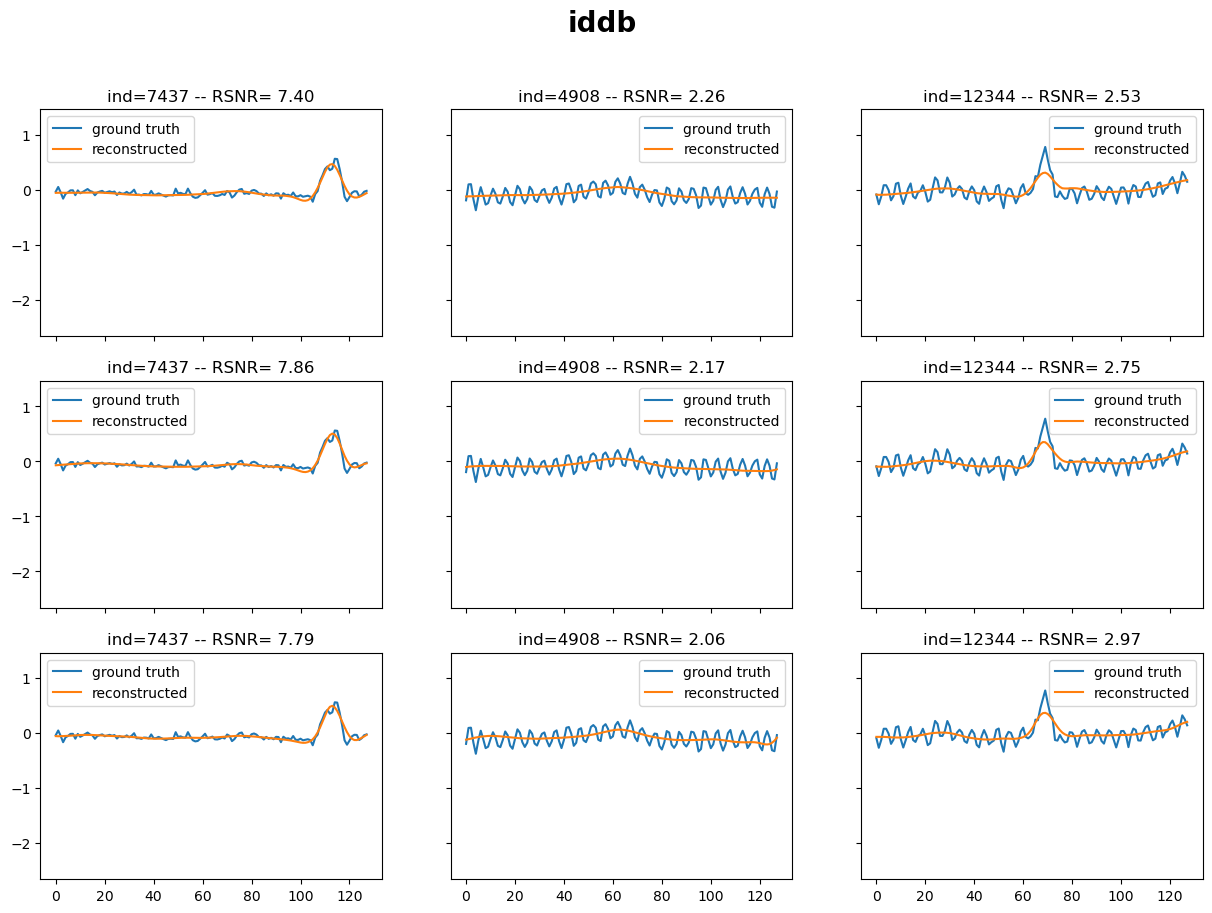

In [ ]:
_data = ecg_iddb
_n_plot = 3

max_iter = len(_white_noise_isnr) * len(_seed_torch)

inds = np.random.randint(0, len(_data), _n_plot) # 4008, 10689

fig, axs = plt.subplots(max_iter, _n_plot, figsize=(5*_n_plot, 10), sharey=True, sharex=True)
fig.suptitle('iddb', fontsize=20, fontweight="bold")
with torch.no_grad():

    for ax, (_w, _s) in zip(axs, itertools.product(_white_noise_isnr, _seed_torch)):


        _df = df_bundle_loaded[(df_param_unique['white_noise_isnr']==_w) &
                            (df_param_unique['seed_torch']==_s)]
        
        _model = _df['model'].iloc[0]

        for _ax, _ind in zip(ax, inds):

            inp = torch.tensor(_data[_ind][np.newaxis], dtype=torch.float)

            out = _model(inp.to(device)).cpu()

            _snr = compute_rsnr(inp, out)[0][0]

            _ax.plot(inp[0, 0], label='ground truth')
            _ax.plot(out[0, 0], label='reconstructed')
            _ax.title.set_text(f'ind={_ind} -- RSNR={_snr: .2f}')
            _ax.set(ylim=(np.quantile(ecg_iddb, 0.001), np.quantile(ecg_iddb_filt, 0.999)))
            _ax.legend()

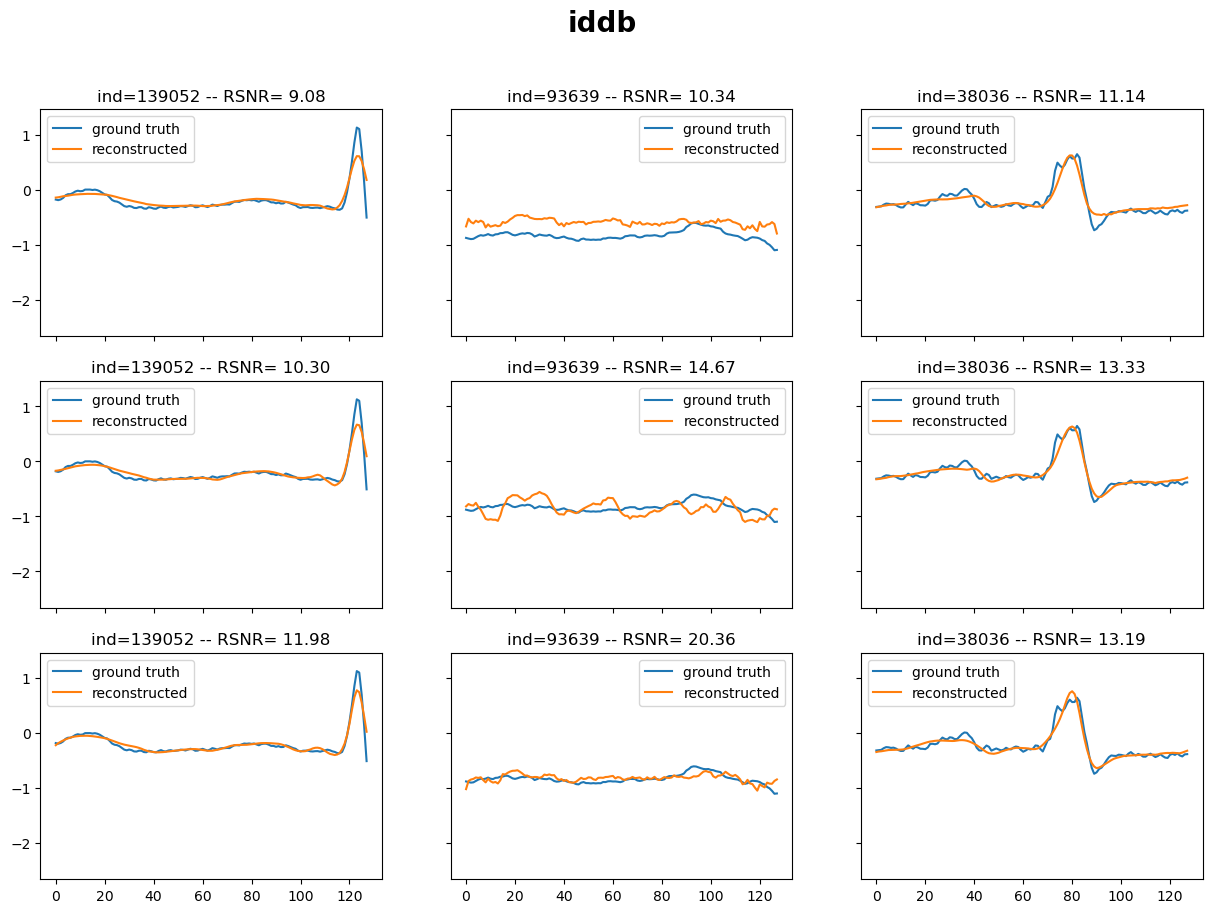

In [ ]:
_data = ecg_mit_bih
_n_plot = 3

max_iter = len(_white_noise_isnr) * len(_seed_torch)

inds = np.random.randint(0, len(_data), _n_plot) # 4008, 10689

fig, axs = plt.subplots(max_iter, _n_plot, figsize=(5*_n_plot, 10), sharey=True, sharex=True)
fig.suptitle('mit_bih', fontsize=20, fontweight="bold")
with torch.no_grad():

    for ax, (_w, _s) in zip(axs, itertools.product(_white_noise_isnr, _seed_torch)):


        _df = df_bundle_loaded[(df_param_unique['white_noise_isnr']==_w) &
                            (df_param_unique['seed_torch']==_s)]
        
        _model = _df['model'].iloc[0]

        for _ax, _ind in zip(ax, inds):

            inp = torch.tensor(_data[_ind][np.newaxis], dtype=torch.float)

            out = _model(inp.to(device)).cpu()

            _snr = compute_rsnr(inp, out)[0][0]

            _ax.plot(inp[0, 0], label='ground truth')
            _ax.plot(out[0, 0], label='reconstructed')
            _ax.title.set_text(f'ind={_ind} -- RSNR={_snr: .2f}')
            _ax.set(ylim=(np.quantile(ecg_iddb, 0.001), np.quantile(ecg_iddb_filt, 0.999)))
            _ax.legend()

In [ ]:
model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True, depth=1)
model_graph.visual_graph

# Multi Unet Training 

### Log parameters

In [17]:
nohup_type = 'serial' # None or 'serial' or 'parallel'

### Experiment path

In [18]:
# path_py = os.path.join('experiments', 'Unet_xbar.py')
path_py = os.path.join('Unet_xbar.py')

### Parameters

In [26]:
#### DATASET PARAMETERS ####

size_ecg = 2_000_000
# size_ecg = 100_000
n = 128
seed_ecg = 11
isnr = 1000

#### A PARAMETERS ####

modeA = 'rakeness'
m = 16                  ################## !!!!!!!! ##################
str_orth = "True"
seed_A = 0
index_A = 0
str_corr = '96af96a7ddfcb2f6059092c250e18f2a'
N_try_A = 100

_ecg_N_forA = 10_000
_n_forA = 128
_fs_forA = 256
_hr0_forA = 60
_hr1_forA = 100
_isnr_forA = 35
_seed_forA = 0

#### UNET PARAMETERS ####

in_channels = 1
seed_torch = [0, 1, 2, 3]
expanded_channels = 32
step_number = 3
kernel_size = 3
str_residual = "True"
str_use_batch_norm = "False"
str_simple_pool = "False"
batch_size = 1024
lr = 0.001
white_noise_var = 0
white_noise_isnr = [20, 25, 30, 35, 40, 45, 50, 55]
str_x_as_input = True
str_A_init = True
str_A_freeze = True


#### HARDWARE PARAMETERS ####

str_gpus = "3"
threads = 1
workers = 1

#### OTHERS ####
str_retrain = "False"
str_resume_train = "False"

_b = cell_vars(pop='_b')

In [27]:
# dict_bundle_cmd = cell_vars(offset=0)
dict_bundle_cmd = _b.copy()
print('all parameters:')
dict_bundle_cmd

all parameters:


{'size_ecg': 2000000,
 'n': 128,
 'seed_ecg': 11,
 'isnr': 1000,
 'modeA': 'rakeness',
 'm': 16,
 'str_orth': 'True',
 'seed_A': 0,
 'index_A': 0,
 'str_corr': '96af96a7ddfcb2f6059092c250e18f2a',
 'N_try_A': 100,
 '_ecg_N_forA': 10000,
 '_n_forA': 128,
 '_fs_forA': 256,
 '_hr0_forA': 60,
 '_hr1_forA': 100,
 '_isnr_forA': 35,
 '_seed_forA': 0,
 'in_channels': 1,
 'seed_torch': [0, 1, 2, 3],
 'expanded_channels': 32,
 'step_number': 3,
 'kernel_size': 3,
 'str_residual': 'True',
 'str_use_batch_norm': 'False',
 'str_simple_pool': 'False',
 'batch_size': 1024,
 'lr': 0.001,
 'white_noise_var': 0,
 'white_noise_isnr': [20, 25, 30, 35, 40, 45, 50, 55],
 'str_x_as_input': True,
 'str_A_init': True,
 'str_A_freeze': True,
 'str_gpus': '3',
 'threads': 1,
 'workers': 1,
 'str_retrain': 'False',
 'str_resume_train': 'False'}

### Unravel

In [28]:
for k, v in dict_bundle_cmd.items():
    if type(v) is list and len(v)==1:
        dict_bundle_cmd[k] = v[0];
dict_bundle_cmd_iter = {_k: _v for _k, _v in dict_bundle_cmd.items() if type(_v) is list}
print('loop over:')
[print('--', k, ':', v) for k, v in dict_bundle_cmd_iter.items()];

print()

dict_bundle_cmd_unravel = unravel_bundle_param(dict_bundle_cmd)[0]
print('tot cmd:', len(dict_bundle_cmd_unravel))

loop over:
-- seed_torch : [0, 1, 2, 3]
-- white_noise_isnr : [20, 25, 30, 35, 40, 45, 50, 55]

tot cmd: 32


### Crate distinct bash commands

In [29]:
cmd_bash = []
for bundle in dict_bundle_cmd_unravel:
    cmd_bash += [from_bundle_to_cmd_bash(path_py, bundle, nohup=False)]

print("example: first cmd line:")
print(cmd_bash[0])


example: first cmd line:
python Unet_xbar.py --size_ecg 2000000 -n 128 --seed_ecg 11 --isnr 1000 --modeA rakeness -m 16 --str_orth True --seed_A 0 --index_A 0 --str_corr 96af96a7ddfcb2f6059092c250e18f2a --N_try_A 100 --_ecg_N_forA 10000 --_n_forA 128 --_fs_forA 256 --_hr0_forA 60 --_hr1_forA 100 --_isnr_forA 35 --_seed_forA 0 --in_channels 1 --expanded_channels 32 --step_number 3 --kernel_size 3 --str_residual True --str_use_batch_norm False --str_simple_pool False --batch_size 1024 --lr 0.001 --white_noise_var 0 --str_x_as_input True --str_A_init True --str_A_freeze True --str_gpus 3 --threads 1 --workers 1 --str_retrain False --str_resume_train False --seed_torch 0 --white_noise_isnr 20


### File for bash results

In [30]:
now = time.localtime()
now = '_'.join(str(i) for i in [now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min])

str_id_cmd = '-'.join([f"{str(k).replace(' ', '')}={str(v).replace(' ', '')}" 
                       for k, v in dict_bundle_cmd_iter.items()])

res_single_file = f"nohup-{now}-local-gpu={str(str_gpus)}-{str_id_cmd}.log"
res_global_file = f"nohup-{now}-global-gpu={str(str_gpus)}-{str_id_cmd}.log" 
print("res_single_file:", res_single_file)
print("res_global_file:", res_global_file)

res_single_file: nohup-2025_1_4_17_22-local-gpu=3-seed_torch=[0,1,2,3]-white_noise_isnr=[20,25,30,35,40,45,50,55].log
res_global_file: nohup-2025_1_4_17_22-global-gpu=3-seed_torch=[0,1,2,3]-white_noise_isnr=[20,25,30,35,40,45,50,55].log


### Merge in one bash command

In [31]:

if nohup_type is not None:
    if nohup_type=='parallel':
        sep_str = f"; nohup "
    elif nohup_type=='serial':
        sep_str = f" >{res_single_file} && "
    else:
        assert False, "nohup_type not in [None, 'parallel' or 'serial'] can be used"
else:
    sep_str = f"; "

cmd_bash_final = sep_str.join(cmd_bash)

if nohup_type is not None:
    if nohup_type=='serial':
        cmd_bash_final = f"nohup sh -c '{cmd_bash_final}'"

if nohup_type:
    cmd_bash_final = cmd_bash_final + f" &> {res_global_file} &"

### Bash commands

In [32]:
print(cmd_bash_final)

nohup sh -c 'python Unet_xbar.py --size_ecg 2000000 -n 128 --seed_ecg 11 --isnr 1000 --modeA rakeness -m 16 --str_orth True --seed_A 0 --index_A 0 --str_corr 96af96a7ddfcb2f6059092c250e18f2a --N_try_A 100 --_ecg_N_forA 10000 --_n_forA 128 --_fs_forA 256 --_hr0_forA 60 --_hr1_forA 100 --_isnr_forA 35 --_seed_forA 0 --in_channels 1 --expanded_channels 32 --step_number 3 --kernel_size 3 --str_residual True --str_use_batch_norm False --str_simple_pool False --batch_size 1024 --lr 0.001 --white_noise_var 0 --str_x_as_input True --str_A_init True --str_A_freeze True --str_gpus 3 --threads 1 --workers 1 --str_retrain False --str_resume_train False --seed_torch 0 --white_noise_isnr 20 >nohup-2025_1_4_17_22-local-gpu=3-seed_torch=[0,1,2,3]-white_noise_isnr=[20,25,30,35,40,45,50,55].log && python Unet_xbar.py --size_ecg 2000000 -n 128 --seed_ecg 11 --isnr 1000 --modeA rakeness -m 16 --str_orth True --seed_A 0 --index_A 0 --str_corr 96af96a7ddfcb2f6059092c250e18f2a --N_try_A 100 --_ecg_N_forA 100

# Unet Parameter exploration

In [ ]:
list_expanded_channels = [64, 32, 16]
list_step_number = [4, 3, 2]
list_kernel_size = [3, 5, 7]

# file_param = 'dummy_Unet_param.pkl'

_unet_many_param(list_expanded_channels, list_step_number, 
                 list_kernel_size, 
                #  file_param,
                 )

{'unet_param': 11521409, 'expanded_channels': 64, 'step_number': 4, 'kernel_size': 3}
{'unet_param': 17796609, 'expanded_channels': 64, 'step_number': 4, 'kernel_size': 5}
{'unet_param': 24071809, 'expanded_channels': 64, 'step_number': 4, 'kernel_size': 7}
{'unet_param': 2860417, 'expanded_channels': 64, 'step_number': 3, 'kernel_size': 3}
{'unet_param': 4417025, 'expanded_channels': 64, 'step_number': 3, 'kernel_size': 5}
{'unet_param': 5973633, 'expanded_channels': 64, 'step_number': 3, 'kernel_size': 7}
{'unet_param': 692609, 'expanded_channels': 64, 'step_number': 2, 'kernel_size': 3}
{'unet_param': 1069569, 'expanded_channels': 64, 'step_number': 2, 'kernel_size': 5}
{'unet_param': 1446529, 'expanded_channels': 64, 'step_number': 2, 'kernel_size': 7}
{'unet_param': 2885313, 'expanded_channels': 32, 'step_number': 4, 'kernel_size': 3}
{'unet_param': 4454145, 'expanded_channels': 32, 'step_number': 4, 'kernel_size': 5}
{'unet_param': 6022977, 'expanded_channels': 32, 'step_number':

### Extract a layer

In [ ]:
unet_param = get_size_model(model)
print(f'total parameter of the Unet: {unet_param}')

total parameter of the Unet: 11521409


In [ ]:
layer_name_list = ['down', 'down_0', 'conv', 'conv_op', '3']
sub_model = get_generic_l(model, layer_name_list)
print(sub_model, '\n\nParam:', get_size_model(sub_model))

Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,)) 

Param: 12352


In [ ]:
layer_name_list = ['down', 'down_0', 'conv']
sub_model = get_generic_l(model, layer_name_list)
print(sub_model, '\n\nParam:', get_size_model(sub_model))

DoubleConv(
  (conv_op): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
) 

Param: 12864


# Model debug

In [39]:
_model = UNet(in_channels = 2, 
              out_channels = 1, 
              expanded_channels = 32, 
              steps_num=3, 
              kernel_size=3, 
              simple_pool=False,
              use_batch_norm=False, 
              residual=True)

_model.to(device)

UNet(
  (down): DownSeq(
    (down_0): DownSample(
      (conv): DoubleConv(
        (conv_op): Sequential(
          (0): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
          (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (3): ReLU(inplace=True)
        )
      )
      (pool): Conv1d(32, 32, kernel_size=(2,), stride=(2,))
    )
    (down_1): DownSample(
      (conv): DoubleConv(
        (conv_op): Sequential(
          (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
          (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (3): ReLU(inplace=True)
        )
      )
      (pool): Conv1d(64, 64, kernel_size=(2,), stride=(2,))
    )
    (down_2): DownSample(
      (conv): DoubleConv(
        (conv_op): Sequential(
          (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
          (2)

In [ ]:

_t_loader = dict_test_loader[_p_dict['mode_A']]

snr_ = 0.0
test_loss = 0
with torch.no_grad():
    for inputs, targets in _t_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = _model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        
        snr_ += np.mean(compute_rsnr(outputs.detach().cpu().numpy(),
                                    targets.detach().cpu().numpy()))
        
test_loss /= len(test_loader)
snr_ /= len(test_loader)

print(f'{_p_dict} -- SNR: {snr_:.2f}')

{'mode_A': 'rakeness', 'use_batch_norm': False, 'seed_torch': 3} -- SNR: 0.66
